In [ ]:
#ignore warings
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
!gdown "https://drive.google.com/uc?id=1-iouAOxNl3IaoGZT85ir2EM-s-t_7Gv9"
!apt-get install git
!git init
!git remote add origin https://github.com/AjayVamsiV/ImageCaptioingBraille.git
!git config core.sparseCheckout true
!echo "Inference" >> .git/info/sparse-checkout
!git pull origin main
!pip install googletrans==4.0.0-rc1
!pip install gTTS

Downloading...
From (original): https://drive.google.com/uc?id=1-iouAOxNl3IaoGZT85ir2EM-s-t_7Gv9
From (redirected): https://drive.google.com/uc?id=1-iouAOxNl3IaoGZT85ir2EM-s-t_7Gv9&confirm=t&uuid=ab15a558-06e7-45e1-99c5-73ed6de900bc
To: /content/resnet49.tar
100% 121M/121M [00:00<00:00, 152MB/s]
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reinitialized existing Git repository in /content/.git/
error: remote origin already exists.
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1009 bytes | 1009.00 KiB/s, done.
From https://github.com/AjayVamsiV/ImageCaptioingBraille
 * branch            main       -> FETCH_HEAD
   cb48279..2b250c6  mai

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm
from PIL import Image
import spacy
import matplotlib.pyplot as plt
from torchvision import models
from Inference.Braille import text_to_braille_ascii
from gtts import gTTS
from googletrans import Translator

spacy_eng = spacy.load("en_core_web_sm")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]

class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Optionally set whether to fine-tune the CNN
        for param in self.resnet.parameters():
            param.requires_grad = self.train_CNN

    def forward(self, images):
        features = self.resnet(images)
        return self.dropout(self.relu(features))

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1) #here features is the output from encoder, embeddings is the word embedding. we concatenate the two and pass it to the lstm
        hiddens, _ = self.lstm(embeddings) #lstm expects the input to be 3D [batch_size, sequence_length, embedding_size] but got 2D, passing the concatenated output to the lstm
        outputs = self.linear(hiddens) #hiddens is the output from the lstm, outputs is the output from the linear layer which is the final output of the decoder
        return outputs

class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = (torch.zeros(self.decoderRNN.lstm.num_layers, 1, self.decoderRNN.lstm.hidden_size).to(device),
                      torch.zeros(self.decoderRNN.lstm.num_layers, 1, self.decoderRNN.lstm.hidden_size).to(device)) # Initialize hidden and cell states with correct dimensions


            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [ ]:
def display_examples(model, device, vocab, image_paths):
    """
    Displays images alongside their predicted captions.

    Parameters:
    - model: The trained image captioning model.
    - device: The device (CPU or GPU) to run inference on.
    - vocab: The vocabulary object used for decoding captions.
    - image_paths: List of file paths to the images to be captioned.
    """
    # Define the transformation pipeline
    transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    model.eval()  # Set the model to evaluation mode

    fig, axes = plt.subplots(len(image_paths),1, figsize=(15, 10))  # Create a row of subplots

    if len(image_paths) == 1:  # Handle case of single image input
        axes = [axes]

    captions = []
    traslations = []
    for idx, image_path in enumerate(image_paths):
        # Load and preprocess the image
        img = transform(Image.open(image_path).convert("RGB")).unsqueeze(0)

        # Predict caption
        caption = " ".join(model.caption_image(img.to(device), vocab))
        translated_text = translate_text(caption, "hi") #Hindi
        captions.append(caption)
        traslations.append(translated_text)

        tts = gTTS(text=caption, lang='en')
        # Save the audio file
        tts.save(f"caption{idx+1}.mp3")
        print(f"caption{idx+1}.mp3 audio created")
        # Load image for display (unprocessed)
        img_display = Image.open(image_path)

        # Plot image and caption
        axes[idx].imshow(img_display)
        # axes[idx].set_title(f"Generated Caption: {caption}", fontsize=10)

        axes[idx].text(
            0.5,
            -0.1,
            f"Predicted Caption: {caption}\nBraille: {text_to_braille_ascii(caption[5:-5])}",#5:-5 to remove SOS and EOS tokens
            fontsize=12,
            ha="center",
            va="top",
            transform=axes[idx].transAxes,
        )
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

    for i in range(len(image_paths)):
        print(f"Caption: {captions[i]}")
        print(f"Translation: {traslations[i]}")

    model.train()  # Reset the model to training mode

translator = Translator()

def translate_text(text, target_language):
    translation = translator.translate(text, dest=target_language)
    return translation.text


caption1.mp3 audio created
caption2.mp3 audio created
caption3.mp3 audio created


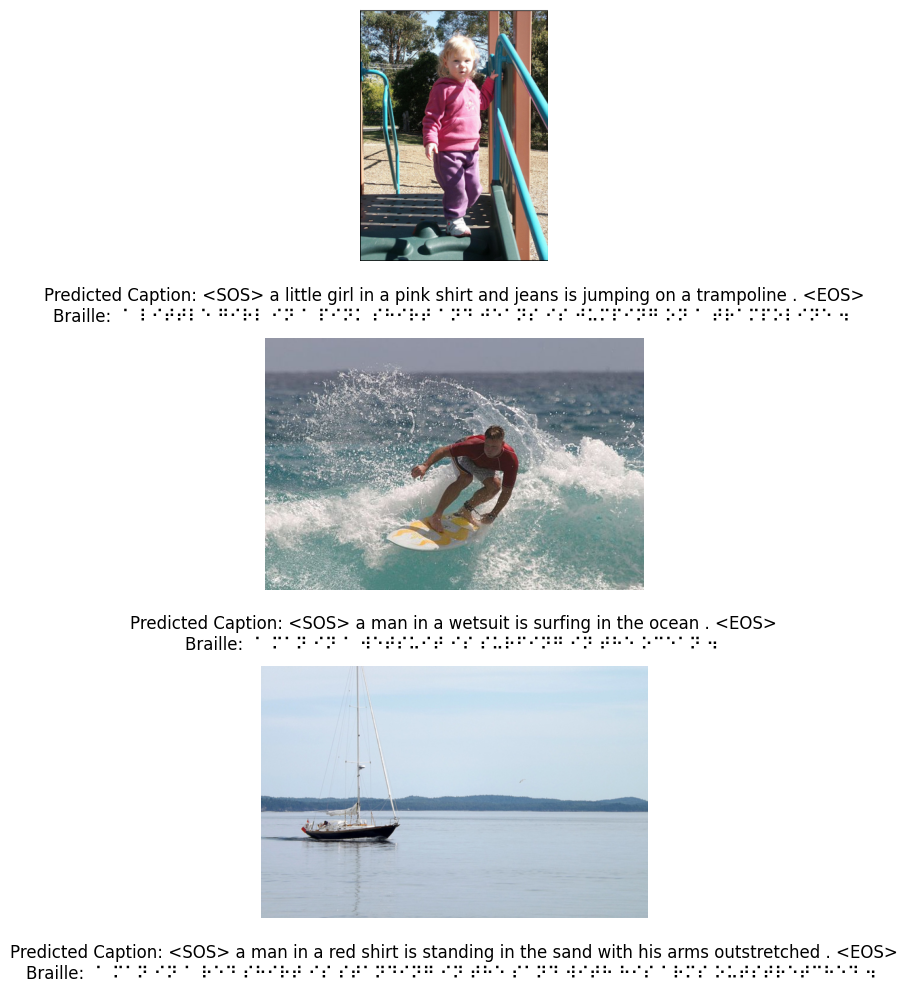

Caption: <SOS> a little girl in a pink shirt and jeans is jumping on a trampoline . <EOS>
Translation: <sos> एक गुलाबी शर्ट और जींस में एक छोटी लड़की एक ट्रम्पोलिन पर कूद रही है।<eos>
Caption: <SOS> a man in a wetsuit is surfing in the ocean . <EOS>
Translation: <sos> एक वेटसूट में एक आदमी समुद्र में सर्फिंग कर रहा है।<eos>
Caption: <SOS> a man in a red shirt is standing in the sand with his arms outstretched . <EOS>
Translation: <sos> एक लाल शर्ट में एक आदमी रेत में अपनी बाहों के साथ खड़ा है।<eos>


In [ ]:
import pickle
#load vocabulary
with open("/content/Inference/vocabulary.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)

#load weights
weights_file = "/content/resnet49.tar"
checkpoint = torch.load(weights_file, map_location=torch.device(device))

#create model
model = CNNtoRNN(embed_size=256, hidden_size=256, vocab_size=len(loaded_vocab.stoi), num_layers=1).to(device)

# Load model weights, ignoring mismatched layers
model_state_dict = model.state_dict()
checkpoint_state_dict = checkpoint["state_dict"]

# Filter out layers that mismatch (e.g., embeddings and linear layers in the decoder)
checkpoint_state_dict = {
    k: v
    for k, v in checkpoint_state_dict.items()
    if k in model_state_dict and v.size() == model_state_dict[k].size()
}

# Update model's state dict with the filtered checkpoint state dict
model_state_dict.update(checkpoint_state_dict)
model.load_state_dict(model_state_dict)

# Function to print some example captions
image_paths = ["/content/Inference/girl.png","/content/Inference/surf.jpg","/content/Inference/boat.png"]
display_examples(model, device, loaded_vocab, image_paths)